In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_225799/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


2024-02-28 14:57:39.125956: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 14:57:39.160864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 14:57:39.160885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 14:57:39.161728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 14:57:39.167381: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

df=data_all.copy()
#data_all=hf.add_MSI_noise(data_all,channel_labels)

##Train test validation split##
X_labels_COT= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','COT']
##Train test validation split##
X_labels_No= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B12']


In [4]:


#X_truth=df_truth[X_labels]


#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)


X_COT=df[X_labels_COT]
X_No=df[X_labels_No]
y=df[y_labels]

X_train_COT, X_test_COT, y_train, y_test=train_test_split(X_COT,y,test_size=0.05)

indexes_training_data=X_train_COT.index
indexes_test_data=X_test_COT.index

X_train_No=X_No.iloc[indexes_training_data]
X_test_No=X_No.iloc[indexes_test_data]



In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train_COT['Cloud_B02'])), int(len(X_train_COT['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train_COT['Cloud_B02'])) if np.any(validation_indices==i)==False]


Best model out of total max epochs found at epoch 229
Model No saved...


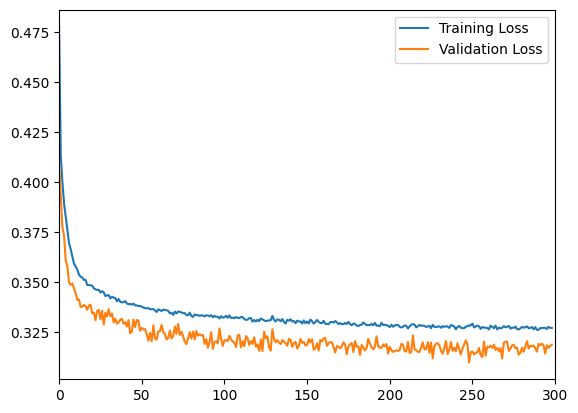

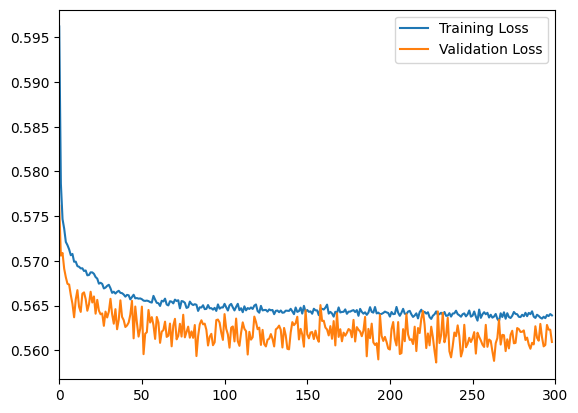

In [6]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500
save=True

nepochs=300
model_COT=QuantileNetwork(quantiles=quantiles)
model_No=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
n_nodes_one=64
sequence_COT=lambda: nn.Sequential(
    nn.Linear(len(X_labels_COT),n_nodes_one),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_one,n_nodes_one),
    nn.ReLU(),
    nn.Linear(n_nodes_one, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)
n_nodes_one=64
sequence_No=lambda: nn.Sequential(
    nn.Linear(len(X_labels_No),n_nodes_one),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_one,n_nodes_one),
    nn.ReLU(),
    nn.Linear(n_nodes_one, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

model_COT.fit(X_train_COT.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_COT(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_in_X/COT',model=model_COT,X_test=X_test_COT,y_test=y_test)
    print("Model COT saved...")

model_No.fit(X_train_No.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_No(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_in_X/No_COT',model=model_No,X_test=X_test_No,y_test=y_test)
    print("Model No saved...")


## Load trained models and Visualise

In [74]:
#Load models
model_COT,X_test_COT,y_test=hf.load_model_and_test_data('pytorch_models/test_COT_in_X/COT')
model_No,X_test_No,y_test=hf.load_model_and_test_data('pytorch_models/test_COT_in_X/No_COT')


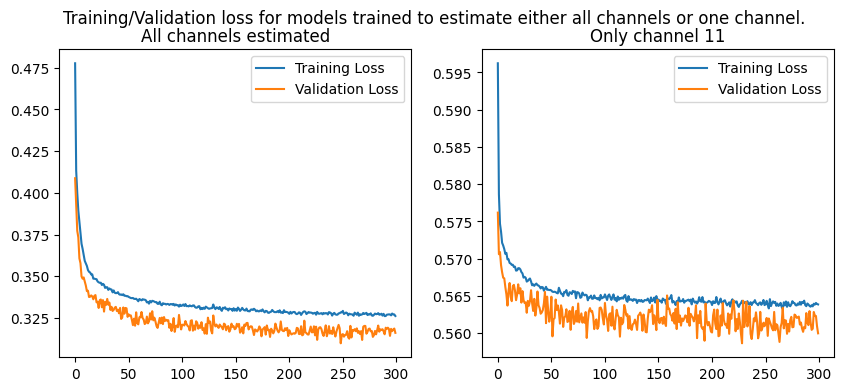

In [75]:
plt.rcParams["figure.figsize"] = [10, 4]
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Training/Validation loss for models trained to estimate either all channels or one channel.")

ax[0].plot(model_COT.train_loss.data.cpu().numpy())
ax[0].plot(model_COT.val_loss.data.cpu().numpy())
ax[0].set_title("All channels estimated")
ax[0].legend(['Training Loss','Validation Loss'])

ax[1].plot(model_No.train_loss.data.cpu().numpy())
ax[1].plot(model_No.val_loss.data.cpu().numpy())
ax[1].set_title("Only channel 11")
ax[1].legend(['Training Loss','Validation Loss'])

In [76]:
cot_limit=True
cot_limit_val=3.6
if cot_limit:
    df_test=df.iloc[X_test_COT.index]
    X_test_COT=df_test[df_test['COT']<cot_limit_val][X_labels_COT]
    X_test_No=df_test[df_test['COT']<cot_limit_val][X_labels_No]
    indexes=X_test_COT.index
    y_test=df.iloc[indexes][y_labels]

In [77]:
#Make predictions
y_preds_COT=model_COT.predict(X_test_COT.to_numpy())
y_preds_COT=y_preds_COT[:,0,:]

y_preds_No=model_No.predict(X_test_No.to_numpy())
y_preds_No=y_preds_No[:,0,:]



In [78]:
## Calculate residuals
y=y_test.to_numpy()[:,0]
res_COT=y-y_preds_COT[:,1]
res_No=y-y_preds_No[:,1]

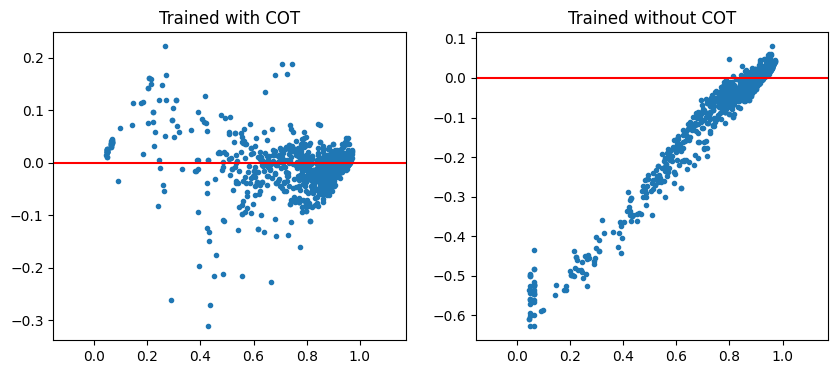

In [79]:
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("")

ax[0].plot(y,res_COT,'.')
ax[0].set_title("Trained with COT")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y)-0.2,np.max(y)+0.2))

ax[1].plot(y,res_No,'.')
ax[1].set_title("Trained without COT")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y)-0.2,np.max(y)+0.2))

plt.show()


In [80]:
r2_all=r2_score(y,y_preds_COT[:,1])
r2_one=r2_score(y,y_preds_No[:,1])
mse_all=mean_squared_error(y,y_preds_COT[:,1])
mse_one=mean_squared_error(y,y_preds_No[:,1])

print("R2 score channel 11, model trained for all channels: "+str(r2_all))
print("R2 score channel 11, model trained for channel 11: "+str(r2_one))
print(" ")
print("MSE score channel 11, model trained for all channels: "+str(mse_all))
print("MSE score channel 11, model trained for channel 11: "+str(mse_one))


R2 score channel 11, model trained for all channels: 0.9624482926802799
R2 score channel 11, model trained for channel 11: 0.4938404249770888
 
MSE score channel 11, model trained for all channels: 0.0013777954438757194
MSE score channel 11, model trained for channel 11: 0.018571308899566562


In [81]:
#samples=len(X_test)
samples=100

/tmp/ipykernel_225799/4188425577.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(x=y_all_samps_sort
/tmp/ipykernel_225799/4188425577.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[1].errorbar(x=y_one_samps_sort


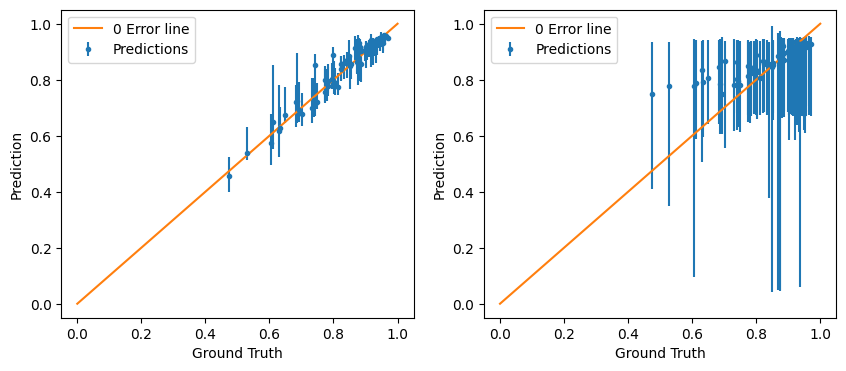

In [82]:

#Get ground truth y, all model
y_all_samps=y[0:samples]
sort_ind=np.argsort(y_all_samps)
y_all_samps_sort=y_all_samps[sort_ind]

#Get y predictions, all model
y_pred_all_samps=y_preds_COT[0:samples,:]
y_pred_all_samps_sort=y_pred_all_samps[sort_ind,:]

#Get ground truth y, one model
y_one_samps=y[0:samples]
sort_ind_one=np.argsort(y_one_samps)
y_one_samps_sort=y_one_samps[sort_ind_one]

#Get y predictions, one model
y_pred_one_samps=y_preds_No[0:samples,:]
y_pred_one_samps_sort=y_pred_one_samps[sort_ind,:]


#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].errorbar(x=y_all_samps_sort
             ,y=y_pred_all_samps_sort[:,1],
             yerr=[np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,0]),
                   np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,2])],
                    marker='.',fmt='.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['0 Error line','Predictions'])
ax[0].set_xlabel("Ground Truth")
ax[0].set_ylabel("Prediction")

ax[1].errorbar(x=y_one_samps_sort
             ,y=y_pred_one_samps_sort[:,1],
             yerr=[np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,0]),
                   np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,2])],
                    marker='.',fmt='.')
ax[1].plot(line,line)
ax[1].legend(['0 Error line','Predictions'])
ax[1].set_xlabel("Ground Truth")
ax[1].set_ylabel("Prediction")

plt.show()

/tmp/ipykernel_225799/2070949516.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(x=np.linspace(0,samples,samples)
/tmp/ipykernel_225799/2070949516.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[1].errorbar(x=np.linspace(0,samples,samples)


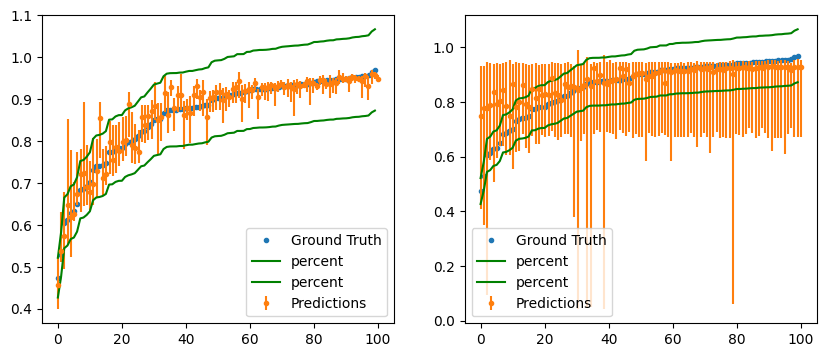

In [83]:

fig,ax =plt.subplots(nrows=1,ncols=2)

ax[0].plot(y_all_samps_sort,'.',label='Ground Truth')
ax[0].errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_all_samps_sort[:,1],
             yerr=[np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,0]),
                   np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,2])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
ax[0].plot(y_all_samps_sort-y_all_samps_sort*percent,'g',label='percent')
ax[0].plot(y_all_samps_sort+y_all_samps_sort*percent,'g',label='percent')
#ax[0].legend(['Ground truth',str(percent*100)+' percent from ground','.','Predictions'])
ax[0].legend()

ax[1].plot(y_one_samps_sort,'.',label='Ground Truth')
ax[1].errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_one_samps_sort[:,1],
             yerr=[np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,0]),
                   np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,2])],
                    marker='.',fmt='.',label='Predictions')

ax[1].plot(y_one_samps_sort-y_all_samps_sort*percent,'g',label='percent')
ax[1].plot(y_one_samps_sort+y_all_samps_sort*percent,'g',label='percent')
ax[1].legend()
#plt.plot(cloudy_sort,'.')
#plt.legend(['Ground truth','Cloudy signal','prediction'])
plt.show()

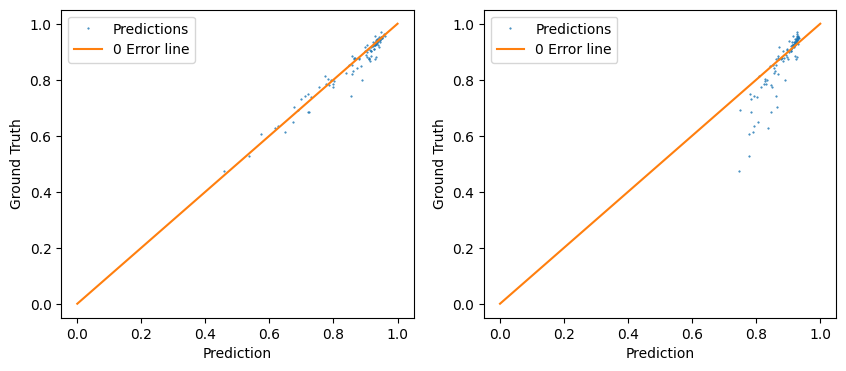

In [84]:
#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].plot(y_pred_all_samps_sort[:,1],y_all_samps_sort,'.',markersize=1)
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['Predictions','0 Error line'])
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Ground Truth")

ax[1].plot(y_pred_one_samps_sort[:,1],y_one_samps_sort,'.',markersize=1)
ax[1].plot(line,line)
ax[1].legend(['Predictions','0 Error line'])
ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("Ground Truth")

plt.show()

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Ground Truth')

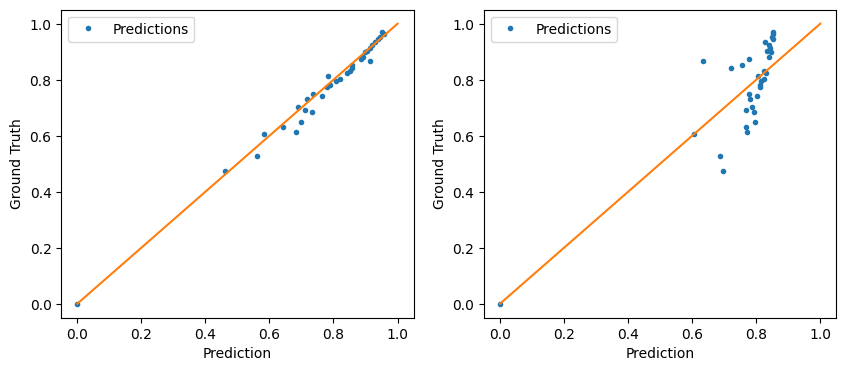

In [85]:
bins=np.linspace(0,1,100)
freq_all_true=np.zeros(len(bins))
freq_all_pred=np.zeros(len(bins))
for i,edge in enumerate(bins):
    if i!=0:
        indices=(y_all_samps_sort>bins[i-1])&(y_all_samps_sort<=edge)
        mean_bin_true=np.mean(y_all_samps_sort[indices])
        mean_bin_pred=np.mean(y_pred_all_samps_sort[indices])
        
        freq_all_true[i]=mean_bin_true
        freq_all_pred[i]=mean_bin_pred



freq_one_true=np.zeros(len(bins))
freq_one_pred=np.zeros(len(bins))
for i,edge in enumerate(bins):
    if i!=0:
        indices=(y_one_samps_sort>bins[i-1])&(y_one_samps_sort<=edge)
        mean_bin_true=np.mean(y_one_samps_sort[indices])
        mean_bin_pred=np.mean(y_pred_one_samps_sort[indices])
        
        freq_one_true[i]=mean_bin_true
        freq_one_pred[i]=mean_bin_pred


#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].plot(freq_all_pred,freq_all_true,'.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['Predictions'])
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Ground Truth")

ax[1].plot(freq_one_pred,freq_one_true,'.')
ax[1].plot(line,line)
ax[1].legend(['Predictions'])
ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("Ground Truth")

In [86]:
len(y_pred_all_samps_sort)

100

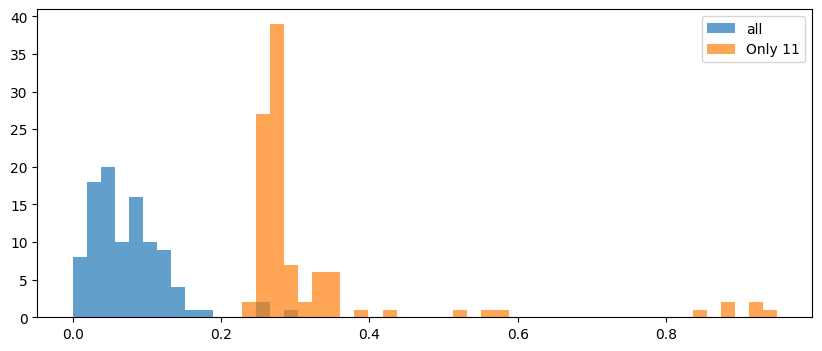

In [87]:
uncertainty_all=y_pred_all_samps_sort[:,2]-y_pred_all_samps_sort[:,0]
uncertainty_one=y_pred_one_samps_sort[:,2]-y_pred_one_samps_sort[:,0]

plt.hist(uncertainty_all,bins=50,range=[0,np.max(np.array([np.max(uncertainty_all),np.max(uncertainty_one)]))],alpha=0.7)
plt.hist(uncertainty_one,bins=50,range=[0,np.max(np.array([np.max(uncertainty_all),np.max(uncertainty_one)]))],alpha=0.7)
plt.legend(['all','Only 11'])

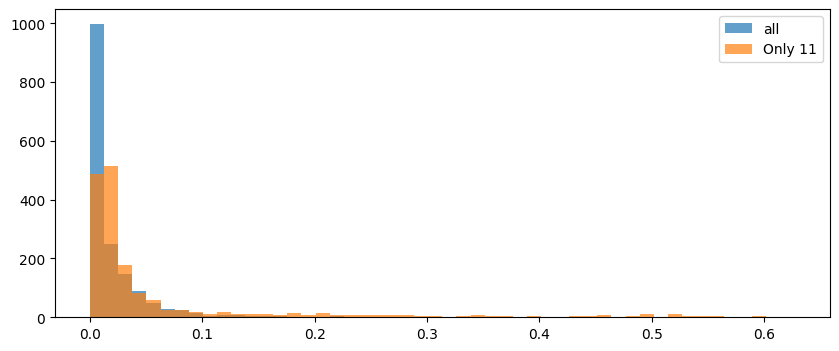

In [88]:
plt.hist(np.abs(res_COT),bins=50,
         range=[0,np.max(np.array([np.max(np.abs(res_COT)),np.max(np.abs(res_No))]))],
         alpha=0.7)
plt.hist(np.abs(res_No),bins=50,
         range=[0,np.max(np.array([np.max(np.abs(res_COT)),np.max(np.abs(res_No))]))],
         alpha=0.7)
plt.legend(['all','Only 11'])

In [89]:
quant_rate_all=QuantileNetwork.quant_rate(y_test.to_numpy()[:,0],y_preds_COT)
quant_rate_one=QuantileNetwork.quant_rate(y_test.to_numpy()[:,0],y_preds_No)

print("Quantile rate, model trained for all channels: "+str(quant_rate_all))
print("Quantile rate, model trained for channel 11: "+str(quant_rate_one))

Quantile rate, model trained for all channels: [0.04857316 0.54826958 0.96114147]
Quantile rate, model trained for channel 11: [0.01700061 0.44383728 0.9143898 ]


In [90]:
quant_cross=QuantileNetwork.quant_cross(y_preds_No)
print("Quantile cross-rate: "+str(quant_cross))

Quantile cross-rate: 0.0
